## Import Packages

In [1]:
# Import all relevant packages
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load images

In [2]:
# Load images first
numImages = len(glob.glob('./images/*jpg'))
images = [None for i in xrange(numImages)]
for fileName in glob.glob('./images/*jpg'):
    fileNum = int(fileName[9:][:-4])
    images[fileNum-1] = np.array(cv2.imread(fileName))
images = np.array(images)

# Load csv data next
train_data = pd.read_csv('data/train.csv').drop(['species'], axis=1).values
train_labels = pd.read_csv('data/train.csv')['species'].values
labels=train_labels.tolist()
train_images = [images[int(data[0]-1)] for data in train_data]
train_ids = [data[0] for data in train_data]
train_data = np.delete(train_data, 0, 1)


test_data = pd.read_csv('data/test.csv').values
test_images = [images[int(data[0]-1)] for data in test_data]
test_ids = [data[0] for data in test_data]
test_data = np.delete(test_data, 0, 1)

del images

## Create MiniBatches

In [3]:
#CNN train data
def img_norm(img):
    t= 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]
    return t
def minibatchData(data,labels_encoded,img_size,channel_num=3,batch_num=30):
    images=[]
    for img in data:
        images.append(np.transpose(img_norm(cv2.resize(img,img_size)),[2,0,1]))
    
    
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(images))
        print(batch_num)
        
        for i in range(int(len(images) / batch_num)):
            minibatch_d = images[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num,img_size[0],img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
            if labels_encoded is not None:
                minibatch_l = labels_encoded[i*batch_num: (i+1)*batch_num]
                batch_labels.append(torch.LongTensor(minibatch_l))
            else:
                minibatch_l = np.zeros(batch_num)
                batch_labels.append(torch.LongTensor(minibatch_l))
        #data, labels = batch_data, batch_labels 
        
    return zip(batch_data, batch_labels)

## Build Training Labels

In [4]:
le= preprocessing.LabelEncoder()
#encode train labels
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)

In [5]:
img_size=(224,224)
cnn_train_data = list(minibatchData(train_images,train_labels_encoded,img_size))
#plt.imshow(cnn_train_data[0][0][3][0])

990
30


594
2


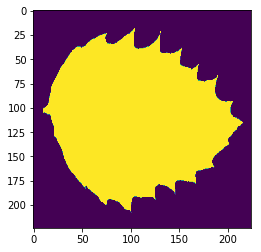

In [6]:
cnn_test_data = list(minibatchData(test_images,None,img_size,batch_num=2))
#print cnn_train_data.size
plt.imshow(cnn_test_data[0][0][1][0])

## Load tuned alexnet instance

In [7]:
filename='tunedAlex.sav'
model_ft = pickle.load(open(filename,'rb'))

## Predict Training Data

In [8]:
probs_cnn_train=np.empty([0,99])
#sm = torch.nn.Softmax()
for data in cnn_train_data:
    images,labels=data
    probs_cnn_train=np.append(probs_cnn_train,(model_ft(images)).data.numpy(),axis=0)
print probs_cnn_train.shape
    

(990, 99)


In [9]:
probs_cnn_test=np.empty([0,99])
for data in cnn_test_data:
    images, labels = data
    probs_cnn_test=np.append(probs_cnn_test,(model_ft(images)).data.numpy(),axis=0)
    #outputs=np.append(outputs,net(images).data.numpy(),axis=0)
    #print probs
    

print probs_cnn_test.shape

#sm = torch.nn.Softmax()
#probabilities = sm(output) 
#print(probabilities)

(594, 99)


## Extract Relevant Features

In [10]:
#separate the 3 histograms
train_margin_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'margin1':'margin64']).values
train_shape_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'shape1':'shape64']).values
train_texture_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'texture1':'texture64']).values

In [11]:
test_margin_data=((pd.read_csv('data/test.csv')).loc[:,'margin1':'margin64']).values
test_shape_data=((pd.read_csv('data/test.csv')).loc[:,'shape1':'shape64']).values
test_texture_data=((pd.read_csv('data/test.csv')).loc[:,'texture1':'texture64']).values

#print train_margin_data.head()
#print train_shape_data.head()
#print train_texture_data.head()

In [12]:
def get_descriptor(images, dense=False):
    sift = cv2.xfeatures2d.SIFT_create()
    des_per_Img = np.array([sift.detectAndCompute(img,None)[1] for img in images])
    return des_per_Img
        
def get_clusters(descriptors, vocabSize):
    des_list = np.concatenate(descriptors)

    kmeans = MiniBatchKMeans(vocabSize, batch_size=100)
    kmeans.fit(np.array(des_list))
    
    return kmeans

def get_vocabulary(descriptors, clusters, vocabSize):
    return np.array([normalize(np.histogram(clusters.predict(dscrs), bins=range(vocabSize))[0].reshape(1,-1)).ravel() for dscrs in descriptors])
        

In [13]:
des_start_time =time.time()
des_list_train = get_descriptor(train_images)

des_list_test = get_descriptor(test_images)
des_end_time =time.time()
print "Descriptors computed in {:2f} seconds".format(des_end_time-des_start_time)

Descriptors computed in 133.268115 seconds


In [14]:
clustering_start_time=time.time()
clusters = get_clusters(des_list_train,150)
clustering_end_time=time.time()
print "Clustering completed in {:2f} seconds".format(clustering_end_time-clustering_start_time)

Clustering completed in 2.823910 seconds


In [15]:
vocab_train = get_vocabulary(des_list_train,clusters,150)
vocab_test = get_vocabulary(des_list_test,clusters,150)

print vocab_train.shape

(990, 149)


## Build deep network

In [62]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils import np_utils
import keras

In [66]:
deep_model = Sequential()

In [67]:
deep_model.add(Dense(512,activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(1024,activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(2048,activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(256,activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(99,activation='softmax'))

In [69]:
deep_model.compile(loss='categorical_crossentropy',optimizer='adam',metric=[keras.metrics.categorical_accuracy])

In [70]:
deep_input=np.array(np.append(train_margin_data,train_texture_data,axis=1))
deep_input=np.array(np.append(deep_input,train_shape_data,axis=1))
deep_input=np.array(np.append(deep_input,vocab_train,axis=1))
deep_input=np.array(np.append(deep_input,probs_cnn_train,axis=1))
Y_labels = np_utils.to_categorical(train_labels_encoded,99)
print deep_input.shape

(990, 440)


## Fit the model

In [71]:
deep_model.fit(deep_input,Y_labels,batch_size=16,epochs=200)
deep_model.summary()

Epoch 1/200
990/990 [==============================] - 7s 7ms/step - loss: 5.0132
Epoch 2/200
990/990 [==============================] - 5s 5ms/step - loss: 4.4938
Epoch 3/200
990/990 [==============================] - 5s 5ms/step - loss: 4.1971
Epoch 4/200
990/990 [==============================] - 5s 5ms/step - loss: 3.8280
Epoch 5/200
990/990 [==============================] - 5s 5ms/step - loss: 3.3897
Epoch 6/200
990/990 [==============================] - 6s 6ms/step - loss: 3.1198
Epoch 7/200
990/990 [==============================] - 6s 6ms/step - loss: 2.8209
Epoch 8/200
990/990 [==============================] - 5s 5ms/step - loss: 2.4798
Epoch 9/200
990/990 [==============================] - 5s 5ms/step - loss: 2.2941
Epoch 10/200
990/990 [==============================] - 5s 5ms/step - loss: 2.0476
Epoch 11/200
990/990 [==============================] - 5s 5ms/step - loss: 2.0619
Epoch 12/200
990/990 [==============================] - 5s 5ms/step - loss: 1.8008
Epoch 13/200


990/990 [==============================] - 5s 5ms/step - loss: 0.8718
Epoch 197/200
990/990 [==============================] - 5s 5ms/step - loss: 1.0644
Epoch 198/200
990/990 [==============================] - 5s 5ms/step - loss: 1.0602
Epoch 199/200
990/990 [==============================] - 5s 5ms/step - loss: 1.0935
Epoch 200/200
990/990 [==============================] - 5s 5ms/step - loss: 0.9436
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               225792    
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024)              0         


## Get Test input space and save output to a file for Kaggle Submission

In [72]:
deep_input_test=np.array(np.append(test_margin_data,test_texture_data,axis=1))
deep_input_test=np.array(np.append(deep_input_test,test_shape_data,axis=1))
deep_input_test=np.array(np.append(deep_input_test,vocab_test,axis=1))
deep_input_test=np.array(np.append(deep_input_test,probs_cnn_test,axis=1))

out_file = deep_model.predict(deep_input_test)
out_file = np.append(np.array(test_ids).reshape(-1,1),out_file,axis=1)

In [73]:
# out_file = generateSubmission(test_ids, test_data,svm_model,99)
headerRow=np.array(['id'] + le.inverse_transform(range(99)).tolist())
df = pd.DataFrame(data=out_file, columns = headerRow)
df['id'] = df['id'].astype(np.int)
df=df.set_index('id')
#print df.head()
# np.set_printoptions(threshold=np.inf)
# print out_file
df.to_csv('output/28_11_18_002(ALexNet15Deep).csv')

/Users/anishsaha/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
